<p><a href="https://colab.research.google.com/github/raul-rufato/smt/blob/newsmt/tutorial/SMT_MixedInteger_application.ipynb" target="_blank" rel="nofollow"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a></p>

<div class="jumbotron text-left"><b>
    
This tutorial describes how to use the SMT toolbox to do some Bayesian Optimization (EGO method) to solve unconstrained optimization problem
<div>
    
Rémy PRIEM, Nathalie BARTOLI and Paul SAVES ONERA/DTIS/M2CI 
    
    May  2023 - version SMT 2.0

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>

The reference paper is available 
here https://www.sciencedirect.com/science/article/pii/S0965997818309360?via%3Dihub 

or as a preprint: http://mdolab.engin.umich.edu/content/python-surrogate-modeling-framework-derivatives

<div class="alert alert-info fade in" id="d110">
<p>In this notebook, two examples are presented to illustrate Bayesian Optimization</p>
<ol> - a 1D-example (xsinx function) where the algorithm is explicitely given and the use of different criteria is presented </ol>
<ol> - a 2D-exemple (Rosenbrock function) where the EGO algorithm from SMT is used  </ol>    
</div>

<div class="alert alert-info fade in" id="d110">
<p>Latest updates</p>
<ol> - add tunneling penalization to improve EGO convergence  </ol>
<ol> - add qEI  to add several interesting points in parallel  </ol>
</div>

In [11]:
!pip install smt

In [12]:
#to avoid warning messages
import warnings
warnings.filterwarnings("ignore")

# Bayesian Optimization 

<IPython.core.display.Javascript object>


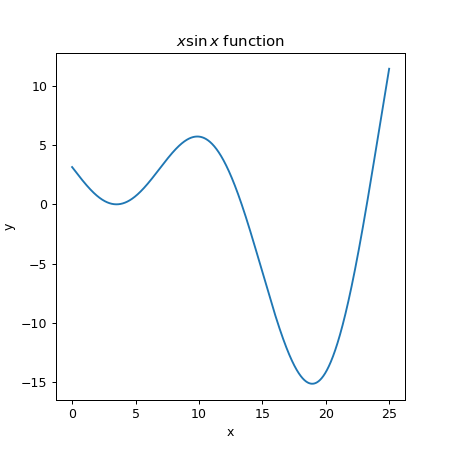

In [13]:

import numpy as np 
%matplotlib notebook
import matplotlib.pyplot as plt

plt.ion()

def fun(point):
    return np.atleast_2d((point-3.5)*np.sin((point-3.5)/(np.pi)))

X_plot = np.atleast_2d(np.linspace(0, 25, 10000)).T
Y_plot = fun(X_plot)


lines = []
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
lines.append(true_fun)
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

#dimension of the problem 
ndim = 1 

Here, the training data are the points xdata=[0,7,25]. 


In [14]:
x_data = np.atleast_2d([0,7,25]).T
y_data = fun(x_data)

Build the GP model with a square exponential kernel with SMT toolbox knowing $(x_{data}, y_{data})$.

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.1376505


<IPython.core.display.Javascript object>


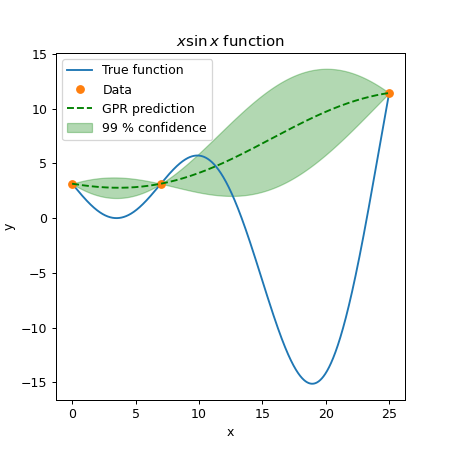

In [15]:
from smt.surrogate_models import KPLS, KRG, KPLSK

########### The Kriging model

# The variable 'theta0' is a list of length ndim.
t = KRG(theta0=[1e-2]*ndim,print_prediction = False, corr='squar_exp')

#Training
t.set_training_values(x_data,y_data)
t.train()



# Prediction of the  points for the plot
Y_GP_plot = t.predict_values(X_plot)
Y_GP_plot_var = t.predict_variances(X_plot)
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot,linestyle='--',color='g')
sig_plus = Y_GP_plot+3*np.sqrt(Y_GP_plot_var)
sig_moins = Y_GP_plot-3*np.sqrt(Y_GP_plot_var)
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
lines = [true_fun,data,gp,un_gp]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(lines,['True function','Data','GPR prediction','99 % confidence'])
plt.show()


Bayesian optimization is defined by Jonas Mockus in (Mockus, 1975) as an optimization technique based upon the minimization of the expected deviation from the extremum of the studied function. 

The objective function is treated as a black-box function. A Bayesian strategy sees the objective as a random function and places a prior over it. The prior captures our beliefs about the behavior of the function. After gathering the function evaluations, which are treated as data, the prior is updated to form the posterior distribution over the objective function. The posterior distribution, in turn, is used to construct an acquisition function (often also referred to as infill sampling criterion) that determines what the next query point should be.

One of the earliest bodies of work on Bayesian optimisation that we are aware of is (Kushner, 1962 ; Kushner, 1964). Kushner used Wiener processes for one-dimensional problems. Kushner’s decision model was based on maximizing the probability of improvement, and included a parameter that controlled the trade-off between ‘more global’ and ‘more local’ optimization, in the same spirit as the Exploration/Exploitation trade-off.

Meanwhile, in the former Soviet Union, Mockus and colleagues developed a multidimensional Bayesian optimization method using linear combinations of Wiener fields, some of which was published in English in (Mockus, 1975). This paper also describes an acquisition function that is based on myopic expected improvement of the posterior, which has been widely adopted in Bayesian optimization as the Expected Improvement function.

In 1998, Jones used Gaussian processes together with the expected improvement function to successfully perform derivative-free optimization and experimental design through an algorithm called  Efficient  Global  Optimization, or EGO (Jones, 1998).

## Efficient Global Optimization

In what follows, we describe the Efficient Global Optimization (EGO) algorithm, as published in (Jones, 1998).

Let $F$ be an expensive black-box function to be minimized. We sample $F$ at the different locations  $X = \{x_1, x_2,\ldots,x_n\}$ yielding the responses $Y = \{y_1, y_2,\ldots,y_n\}$. We build a Kriging model (also called Gaussian process) with a mean function $\mu$ and a variance function $\sigma^{2}$.

The next step is to compute the criterion EI. To do this, let us denote:
$$f_{min} = \min \{y_1, y_2,\ldots,y_n\}.$$
The Expected Improvement funtion (EI) can be expressed:
$$E[I(x)] = E[\max(f_{min}-Y, 0)],$$
where $Y$ is the random variable following the distribution $\mathcal{N}(\mu(x), \sigma^{2}(x))$.
By expressing the right-hand side of EI expression as an integral, and applying some tedious integration by parts, one can express the expected improvement in closed form: 
$$
E[I(x)] = (f_{min} - \mu(x))\Phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right) + \sigma(x) \phi\left(\frac{f_{min} - \mu(x)}{\sigma(x)}\right)
$$
where $\Phi(\cdot)$ and $\phi(\cdot)$ are respectively the cumulative and probability density functions of $\mathcal{N}(0,1)$.

Next, we determine our next sampling point as :
\begin{align}
x_{n+1} = \arg \max_{x} \left(E[I(x)]\right)
\end{align}

We then test the response $y_{n+1}$ of our black-box function $F$ at $x_{n+1}$, rebuild the model taking into account the new information gained, and research the point of maximum expected improvement again.

We summarize here the EGO algorithm:

EGO(F, $n_{iter}$) \# Find the best minimum of $\operatorname{F}$ in $n_{iter}$ iterations  
For ($i=0:n_{iter}$)  

* $mod = {model}(X, Y)$  \# surrogate model based on sample vectors $X$ and $Y$  
* $f_{min} = \min Y$  
* $x_{i+1} = \arg \max {EI}(mod, f_{min})$ \# choose $x$ that maximizes EI  
* $y_{i+1} = {F}(x_{i+1})$ \# Probe the function at most promising point $x_{i+1}$  
* $X = [X,x_{i+1}]$  
* $Y = [Y,y_{i+1}]$   
* $i = i+1$  

$f_{min} = \min Y$  
Return : $f_{min}$ \# This is the best known solution after $n_{iter}$ iterations

Now we want to optimize this function by using Bayesian Optimization and comparing
- Surrogate Based optimization (SBO)
- Expected Improvement criterion (EI)


In a first step we compute the EI criterion

<IPython.core.display.Javascript object>


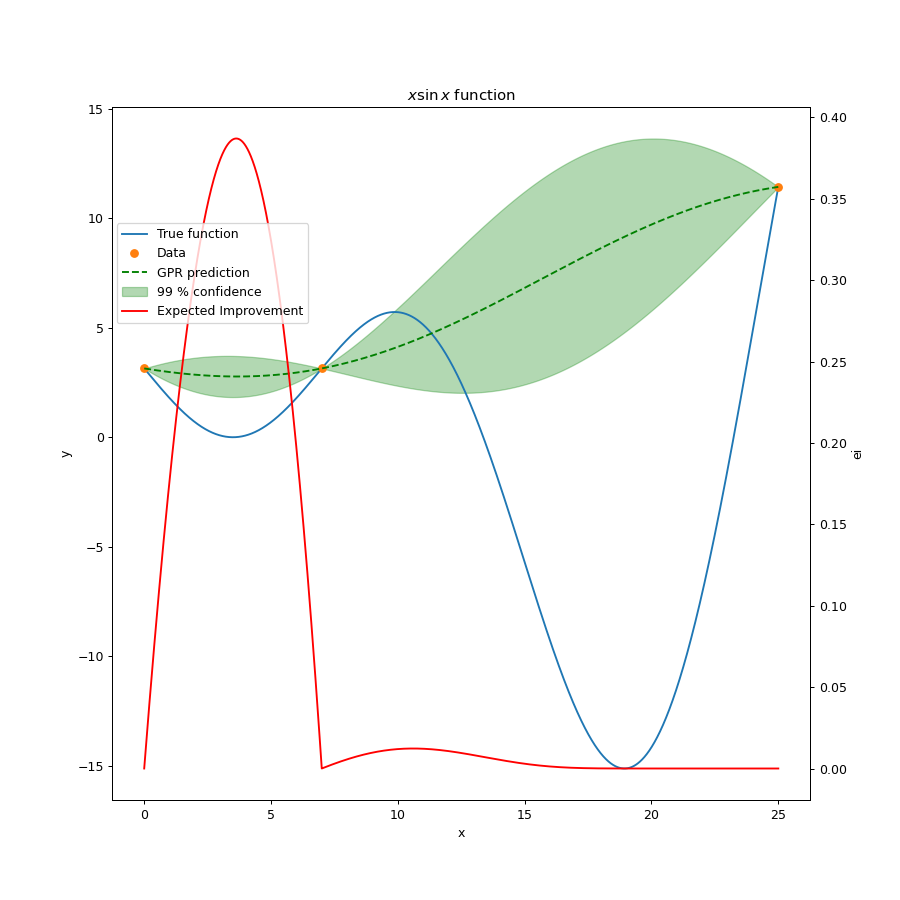

In [16]:
from scipy.stats import norm
from scipy.optimize import minimize

def EI(GP,points,f_min):
    pred = GP.predict_values(points)
    var = GP.predict_variances(points)
    args0 = (f_min - pred)/np.sqrt(var)
    args1 = (f_min - pred)*norm.cdf(args0)
    args2 = np.sqrt(var)*norm.pdf(args0)

    if var.size == 1 and var == 0.0:  # can be use only if one point is computed
        return 0.0
   
    
    ei = args1 + args2
    return ei



Y_GP_plot = t.predict_values(X_plot)
Y_GP_plot_var  =  t.predict_variances(X_plot)
Y_EI_plot = EI(t,X_plot,np.min(y_data))

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)
true_fun, = ax.plot(X_plot,Y_plot)
data, = ax.plot(x_data,y_data,linestyle='',marker='o')
gp, = ax.plot(X_plot,Y_GP_plot,linestyle='--',color='g')
sig_plus = Y_GP_plot+3*np.sqrt(Y_GP_plot_var)
sig_moins = Y_GP_plot-3*np.sqrt(Y_GP_plot_var)
un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
ax1 = ax.twinx()
ei, = ax1.plot(X_plot,Y_EI_plot,color='red')
lines = [true_fun,data,gp,un_gp,ei]
ax.set_title('$x \sin{x}$ function')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax1.set_ylabel('ei')
fig.legend(lines,['True function','Data','GPR prediction','99 % confidence','Expected Improvement'],loc=[0.13,0.64])
plt.show()




Now we compute the EGO method and compare it to other infill criteria 
- SBO (surrogate based optimization): directly using the prediction of the surrogate model ($\mu$)
- LCB (Lower Confidence bound): using the confidence interval : $\mu -3 \times \sigma$
- EI for expected Improvement (EGO)

In [17]:
#surrogate Based optimization: min the Surrogate model by using the mean mu
def SBO(GP,point):
    res = GP.predict_values(point)
    return res

#lower confidence bound optimization: minimize by using mu - 3*sigma
def LCB(GP,point):
    pred = GP.predict_values(point)
    var = GP.predict_variances(point)
    res = pred-3.*np.sqrt(var)
    return res


In [18]:
IC = 'EI'

In [19]:
import matplotlib.image as mpimg
import matplotlib.animation as animation
from IPython.display import HTML


plt.ioff()

x_data = np.atleast_2d([0,7,25]).T
y_data = fun(x_data)

n_iter = 15

gpr = KRG(theta0=[1e-2]*ndim,print_global = False)


for k in range(n_iter):
    x_start = np.atleast_2d(np.random.rand(20)*25).T
    f_min_k = np.min(y_data)
    gpr.set_training_values(x_data,y_data)
    gpr.train()
    if IC == 'EI':
        obj_k = lambda x: -EI(gpr,np.atleast_2d(x),f_min_k)[:,0]
    elif IC =='SBO':
        obj_k = lambda x: SBO(gpr,np.atleast_2d(x))
    elif IC == 'LCB':
        obj_k = lambda x: LCB(gpr,np.atleast_2d(x))
    
    opt_all = np.array([minimize(lambda x: float(obj_k(x)), x_st, method='SLSQP', bounds=[(0,25)]) for x_st in x_start])
    opt_success = opt_all[[opt_i['success'] for opt_i in opt_all]]
    obj_success = np.array([opt_i['fun'] for opt_i in opt_success])
    ind_min = np.argmin(obj_success)
    opt = opt_success[ind_min]
    x_et_k = opt['x']
    
    y_et_k = fun(x_et_k)
    
    y_data = np.atleast_2d(np.append(y_data,y_et_k)).T
    x_data = np.atleast_2d(np.append(x_data,x_et_k)).T
    
    Y_GP_plot = gpr.predict_values(X_plot)
    Y_GP_plot_var  =  gpr.predict_variances(X_plot)
    Y_EI_plot = -EI(gpr,X_plot,f_min_k)

    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111)
    if IC == 'LCB' or IC == 'SBO':
        ei, = ax.plot(X_plot,Y_EI_plot,color='red')
    else:    
        ax1 = ax.twinx()
        ei, = ax1.plot(X_plot,Y_EI_plot,color='red')
    true_fun, = ax.plot(X_plot,Y_plot)
    data, = ax.plot(x_data[0:k+3],y_data[0:k+3],linestyle='',marker='o',color='orange')
    opt, = ax.plot(x_data[k+3],y_data[k+3],linestyle='',marker='*',color='r')
    gp, = ax.plot(X_plot,Y_GP_plot,linestyle='--',color='g')
    sig_plus = Y_GP_plot+3*np.sqrt(Y_GP_plot_var)
    sig_moins = Y_GP_plot-3*np.sqrt(Y_GP_plot_var)
    un_gp = ax.fill_between(X_plot.T[0],sig_plus.T[0],sig_moins.T[0],alpha=0.3,color='g')
    lines = [true_fun,data,gp,un_gp,opt,ei]
    ax.set_title('$x \sin{x}$ function')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(lines,['True function','Data','GPR prediction','99 % confidence','Next point to Evaluate','Infill Criteria'])
    plt.savefig('Optimisation %d' %k)
    plt.close(fig)
    
ind_best = np.argmin(y_data)
x_opt = x_data[ind_best]
y_opt = y_data[ind_best]

print('Results : X = %s, Y = %s' %(x_opt,y_opt))

fig = plt.figure(figsize=[10,10])

ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ims = []
for k in range(n_iter):
    image_pt = mpimg.imread('Optimisation %d.png' %k)
    im = plt.imshow(image_pt)
    ims.append([im])
    
ani = animation.ArtistAnimation(fig, ims,interval=500)
HTML(ani.to_jshtml())




Results : X = [18.94693489], Y = [-15.12498915]


 ## Use the EGO from SMT 

In [20]:
from smt.applications.ego import EGO
from smt.sampling_methods import LHS
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    IntegerVariable,
    OrdinalVariable,
    CategoricalVariable,
)

* Choose your criterion to perform the optimization: EI, SBO or LCB
* Choose the size of the initial DOE
* Choose the number of EGO iterations

## Try with a 2D function : 2D Rosenbrock function 

Rosenbrock Function  in dimension N

$$
f(\mathbf{x}) = \sum_{i=1}^{N-1} 100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2 \quad \mbox{where} \quad \mathbf{x} = [x_1, \ldots, x_N] \in \mathbb{R}^N.
$$

$$x_i \in [-2,2]$$

In [49]:
#define the rosenbrock function
def rosenbrock(x):
    """
    Evaluate objective and constraints for the Rosenbrock test case:
    """
    n,dim = x.shape

    #parameters:
    Opt =[]
    Opt_point_scalar = 1
    #construction of O vector
    for i in range(0, dim):
        Opt.append(Opt_point_scalar)

    #Construction of Z vector
    Z= np.zeros((n,dim))
    for i in range(0,dim):
        Z[:,i] = (x[:,i]-Opt[i]+1)

    #Sum
    sum1 = np.zeros((n,1))
    for i in range(0,dim-1):
        sum1[:,0] += 100*(((Z[:,i]**2)-Z[:,i+1])**2)+((Z[:,i]-1)**2)

    return sum1


xlimits=np.array([[-2,2], [-2,2]])

<IPython.core.display.Javascript object>


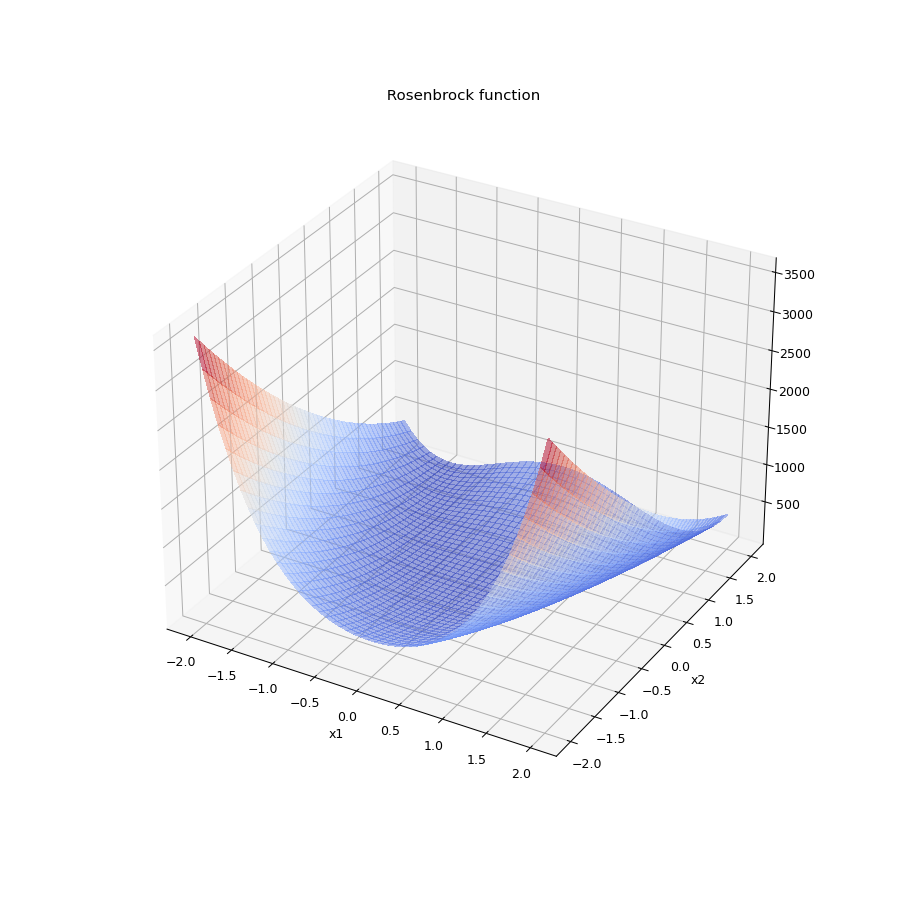

In [50]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

#To plot the Rosenbrock function
num_plot = 50 #to plot rosenbrock
x = np.linspace(xlimits[0][0],xlimits[0][1],num_plot)
res = []
for x0 in x:
    for x1 in x:
        res.append(rosenbrock(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=[10,10])
ax =  fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, res, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
plt.title(' Rosenbrock function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [51]:
criterion='EI' #'EI' or 'SBO' or 'LCB'

#number of points in the initial DOE
ndoe = 10 #(at least ndim+1)

#number of iterations with EGO 
n_iter = 30

design_space = DesignSpace(xlimits)

#Build the initial DOE, add the random_state option to have the reproducibility of the LHS points
sampling = LHS(xlimits=xlimits, random_state=1)
xdoe = sampling(ndoe)



#EGO call
sm=KRG(design_space=design_space, n_start=25, print_global=False)

ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=sm,
    n_start=30,#to do multistart for maximizing the acquisition function
)


x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=rosenbrock)

print('Xopt for Rosenbrock ', x_opt,y_opt, ' obtained using EGO criterion = ', criterion )
print('Check if the optimal point is Xopt= (1,1) with the Y value=0')
print('if not you can increase the number of iterations with n_iter but the CPU will increase also.')
print('---------------------------')

Xopt for Rosenbrock  [1.13317816 1.26809819] [0.04331898]  obtained using EGO criterion =  EI
Check if the optimal point is Xopt= (1,1) with the Y value=0
if not you can increase the number of iterations with n_iter but the CPU will increase also.
---------------------------


<IPython.core.display.Javascript object>


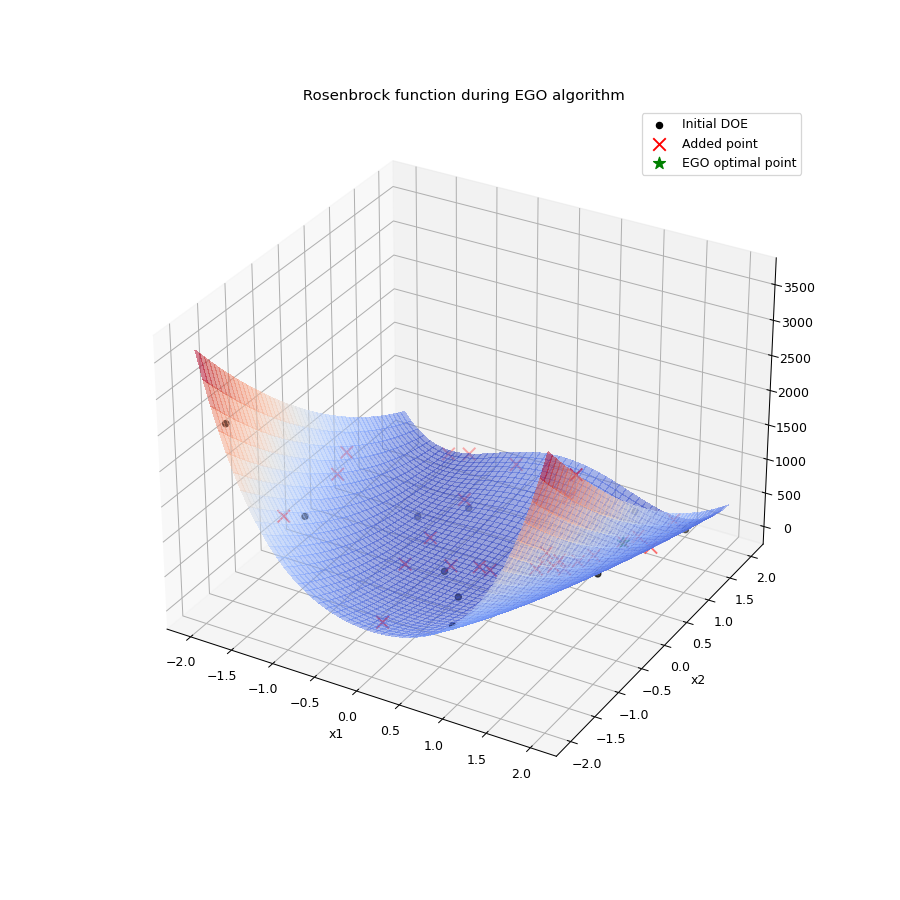

<IPython.core.display.Javascript object>


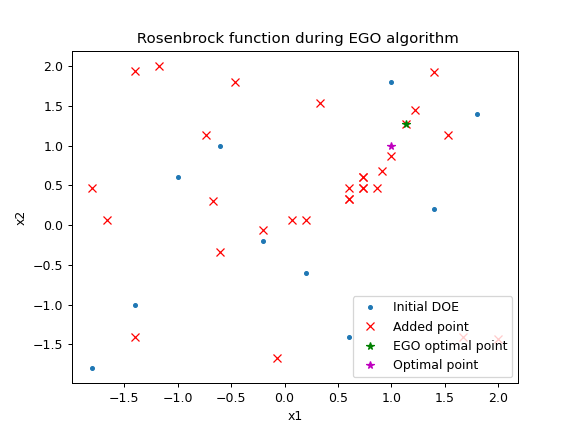

In [52]:
#To plot the Rosenbrock function
#3D plot
x = np.linspace(xlimits[0][0],xlimits[0][1],num_plot)
res = []
for x0 in x:
    for x1 in x:
        res.append(rosenbrock(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=(10, 10))
ax =  fig.add_subplot(projection='3d')

surf = ax.plot_surface(X, Y, res, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,alpha=0.5)
#to add the points provided by EGO
ax.scatter(x_data[:ndoe,0],x_data[:ndoe,1],y_data[:ndoe],zdir='z',marker = '.',c='k',s=100, label='Initial DOE')
ax.scatter(x_data[ndoe:,0],x_data[ndoe:,1],y_data[ndoe:],zdir='z',marker = 'x',c='r', s=100, label= 'Added point')
ax.scatter(x_opt[0],x_opt[1],y_opt,zdir='z',marker = '*',c='g', s=100, label= 'EGO optimal point')

plt.title(' Rosenbrock function during EGO algorithm')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()


#2D plot 
#to add the points provided by EGO
plt.plot(x_data[:ndoe,0],x_data[:ndoe,1],'.', label='Initial DOE')
plt.plot(x_data[ndoe:,0],x_data[ndoe:,1],'x', c='r', label='Added point')
plt.plot(x_opt[:1],x_opt[1:],'*',c='g', label= 'EGO optimal point')
plt.plot([1], [1],'*',c='m', label= 'Optimal point')

plt.title(' Rosenbrock function during EGO algorithm')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()


We can now compare the results by using only the mean information provided by surrogate model approximation


In [53]:
criterion='SBO' #'EI' or 'SBO' or 'LCB'

#number of iterations with EGO 
n_iter = 30


#EGO call with the same initial DOE as before 
ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    surrogate=sm,
    n_start=30,#to do multistart for maximizing the acquisition function
)


x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=rosenbrock)

print('Xopt for Rosenbrock ', x_opt, y_opt, ' obtained using EGO criterion = ', criterion)
print('Check if the optimal point is Xopt=(1,1) with the Y value=0')
print('---------------------------')

Xopt for Rosenbrock  [0.99908267 0.99726456] [8.21347617e-05]  obtained using EGO criterion =  SBO
Check if the optimal point is Xopt=(1,1) with the Y value=0
---------------------------


## EGO and tunneling penalization

The main idea of tunneling  is to penalize the acquisition function in the neighbourhood of already evaluated points. The associated reference is given by:

Zhang, S., & Norato, J. A. (2018, August). Finding better local optima in topology optimization via tunneling. In International Design Engineering Technical Conferences and Computers and Information in Engineering Conference (Vol. 51760, p. V02BT03A014). American Society of Mechanical Engineers.


In [26]:

from smt.applications.mixed_integer import MixedIntegerSurrogateModel
from smt.applications.mixed_integer import MixedIntegerSamplingMethod
from smt.sampling_methods import FullFactorial

Definition of the plot function for 1D

In [27]:
def PlotEgo(criterion, Xsol, Ysol,  xdoe, bounds,npt,n_iter,tunneling, sm) :
    ego = EGO(n_iter=n_iter, criterion=criterion, xdoe=xdoe, n_start=20,n_max_optim=35,enable_tunneling=tunneling, surrogate=sm)
    x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=fun)
    print("Minimum in x={:.0f} with fun(x)={:.10f}".format(int(x_opt), float(y_opt)))

    x_plot = np.atleast_2d(np.linspace(bounds[0][0], bounds[0][1], 9*(npt-1)+1)).T
    fig = plt.figure(figsize=[15, 15])
    n_doe = xdoe.size
    for i in range(n_iter):
        k = n_doe + i
        x_data_k = x_data[0:k]
        y_data_k = y_data[0:k]
        
            #if check list, not already evaluated
        y_data[k]=fun(x_data[k][:, np.newaxis])
        ego.gpr.set_training_values(x_data_k, y_data_k)
        ego.gpr.train()
        y_gp_plot = ego.gpr.predict_values(x_plot)
        y_gp_plot_var = ego.gpr.predict_variances(x_plot)
        y_ei_plot = ego.EI(x_plot,False)
        ax = fig.add_subplot((n_iter + 1) // 2, 2, i + 1)
        ax1 = ax.twinx()
        ei, = ax1.plot(x_plot, y_ei_plot, color="red")

        true_fun = ax.scatter(Xsol, Ysol,color='k',marker='d')
        data, = ax.plot(
            x_data_k, y_data_k, linestyle="", marker="o", color="orange"
        )
        if i < n_iter - 1:
            opt, = ax.plot(
                x_data[k], y_data[k], linestyle="", marker="*", color="r"
            )
            print(x_data[k], y_data[k])
        gp, = ax.plot(x_plot, y_gp_plot, linestyle="--", color="g")        
        sig_plus = y_gp_plot + 3 * np.sqrt(y_gp_plot_var)
        sig_moins = y_gp_plot - 3 * np.sqrt(y_gp_plot_var)
        un_gp = ax.fill_between(
            x_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
        )
        lines = [true_fun, data, gp, un_gp, opt, ei]
        fig.suptitle("EGO optimization of a set of points")
        fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
        ax.set_title("iteration {}".format(i + 1))
        fig.legend(
            lines,
            [
                "set of points",
                "Given data points",
                "Kriging prediction",
                "Kriging 99% confidence interval",
                "Next point to evaluate",
                "Expected improvment function",
            ],
        )
    plt.show()

### Tunneling for 1D function 

In [28]:
def fun(point):
    return np.atleast_2d((point-3.5)*np.sin((point-3.5)/(np.pi)))
bounds = np.array([[0, 25]])
xlimits=bounds
design_space = DesignSpace(
            [
                IntegerVariable(bounds[0][0],bounds[0][1]), #to have integer variable
            ])

<IPython.core.display.Javascript object>


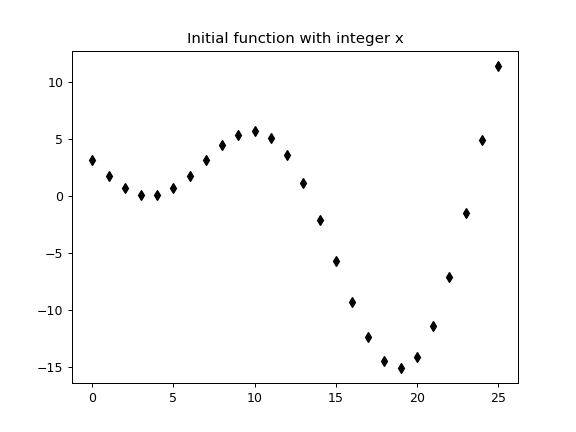

In [29]:
X_plot = np.atleast_2d(np.arange(xlimits[0][0], xlimits[0][1]+1, 1)) 
Y_plot = fun(X_plot)
npts = np.shape(X_plot)[1]
plt.plot(X_plot,Y_plot,'kd')
plt.title('Initial function with integer x')
plt.show()

In [30]:
criterion = "EI"  #'EI' or 'SBO' or 'LCB'

sm = KRG(design_space=design_space,print_global=False)
sampling = MixedIntegerSamplingMethod(FullFactorial, design_space)

xdoe = sampling(4)
n_iter = 3
ego = EGO(
            xdoe=xdoe,
            n_iter=n_iter,
            criterion=criterion,
            surrogate=sm,
            enable_tunneling=True, #to impose tunneling
            random_state=42,
            n_start=30,
        )

x_opt, y_opt, _, _, _ = ego.optimize(fun=fun)

In [31]:
print('Xopt for xsinx function, ', x_opt, y_opt, ' obtained using EGO criterion = ', criterion)
print('Check if the optimal point is 19 associated to y=-15.12')
print('---------------------------')

Xopt for xsinx function,  [19.] [-15.12161154]  obtained using EGO criterion =  EI
Check if the optimal point is 19 associated to y=-15.12
---------------------------


<IPython.core.display.Javascript object>


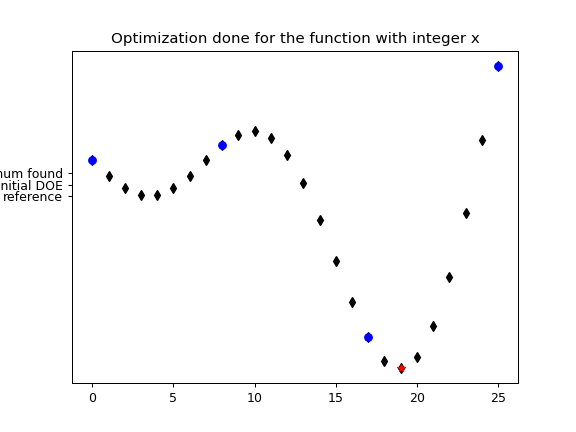

In [32]:
plt.plot(X_plot,Y_plot,'kd','reference')
plt.plot(xdoe,fun(xdoe),'bo','initial DOE')
plt.plot(x_opt,y_opt,'r*','Optimum found')
plt.title('Optimization done for the function with integer x')
plt.show()

Minimum in x=20 with fun(x)=-14.1545328777
[14.] [-2.09283123]
[20.] [-14.15453288]
[4.] [0.07924194]
[22.] [-7.10960014]


<IPython.core.display.Javascript object>


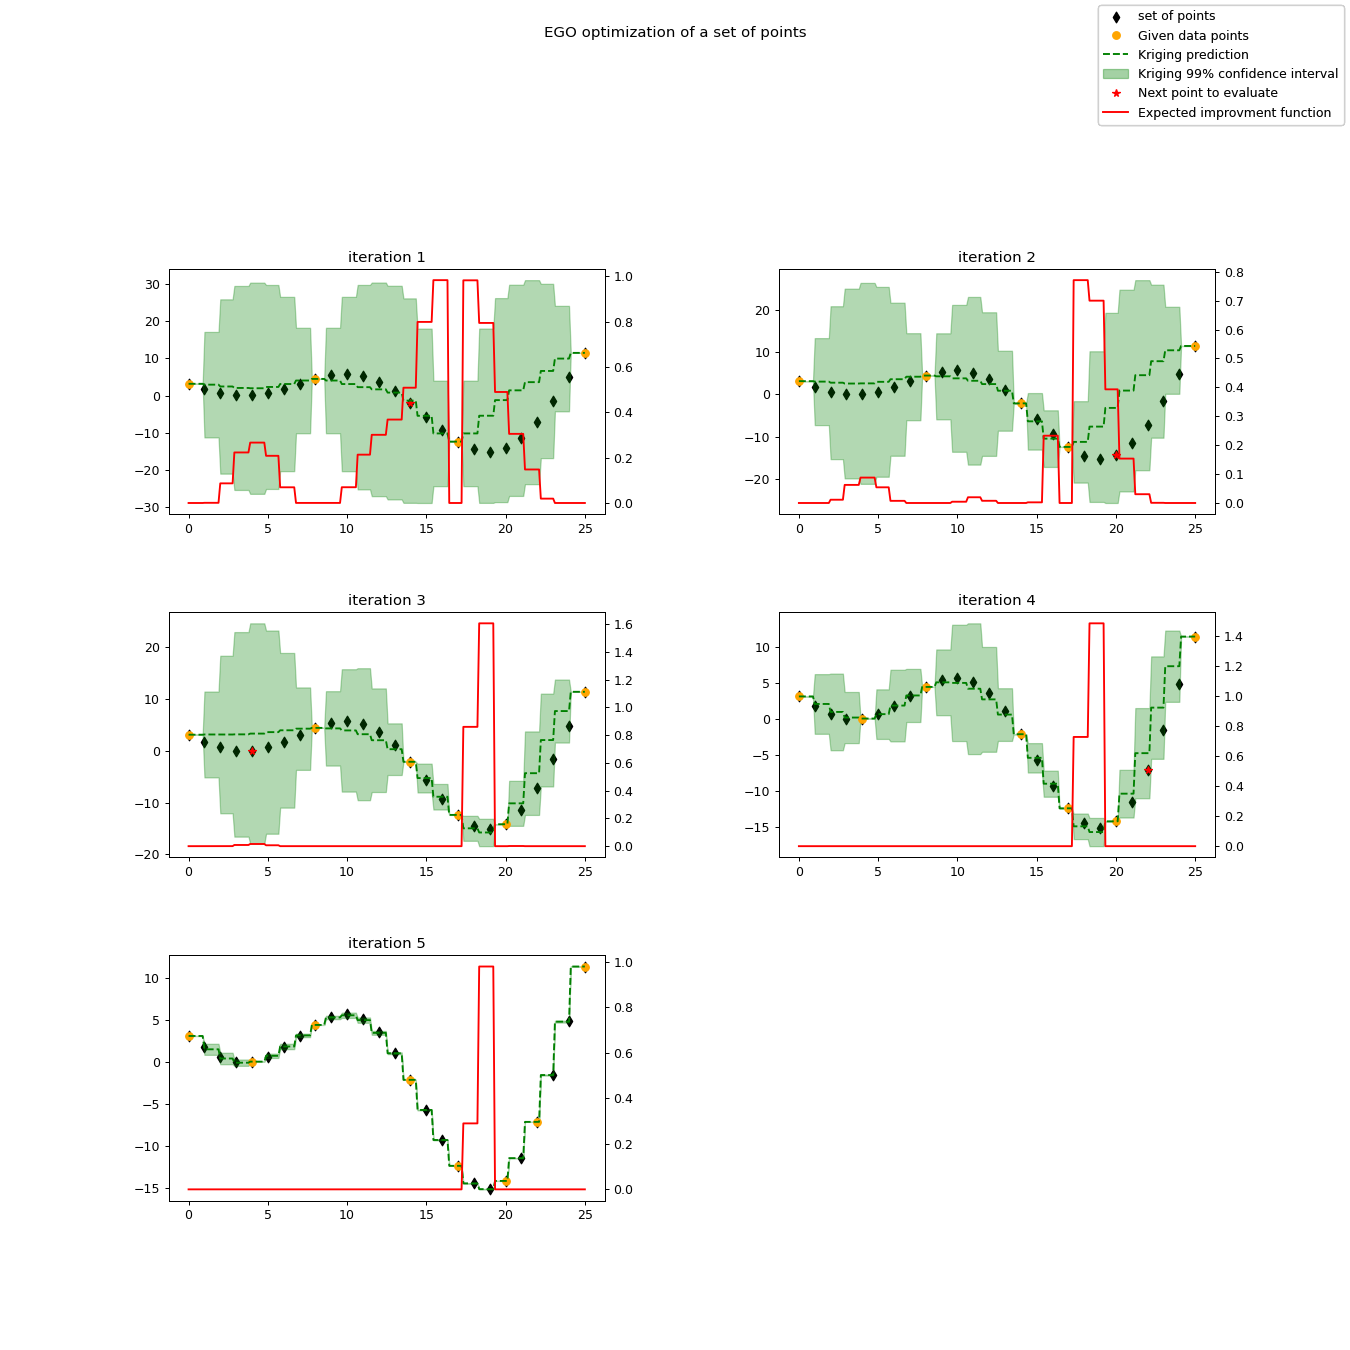

In [33]:
# To have a nice plot with the different iterations
tunneling=True
n_iter = 5

PlotEgo(criterion, X_plot, Y_plot, xdoe, bounds,npts,n_iter,tunneling, sm) 

## qEI example to add several interesting points 

Minimum in x=19.0 with f(x)=-15.1


<IPython.core.display.Javascript object>


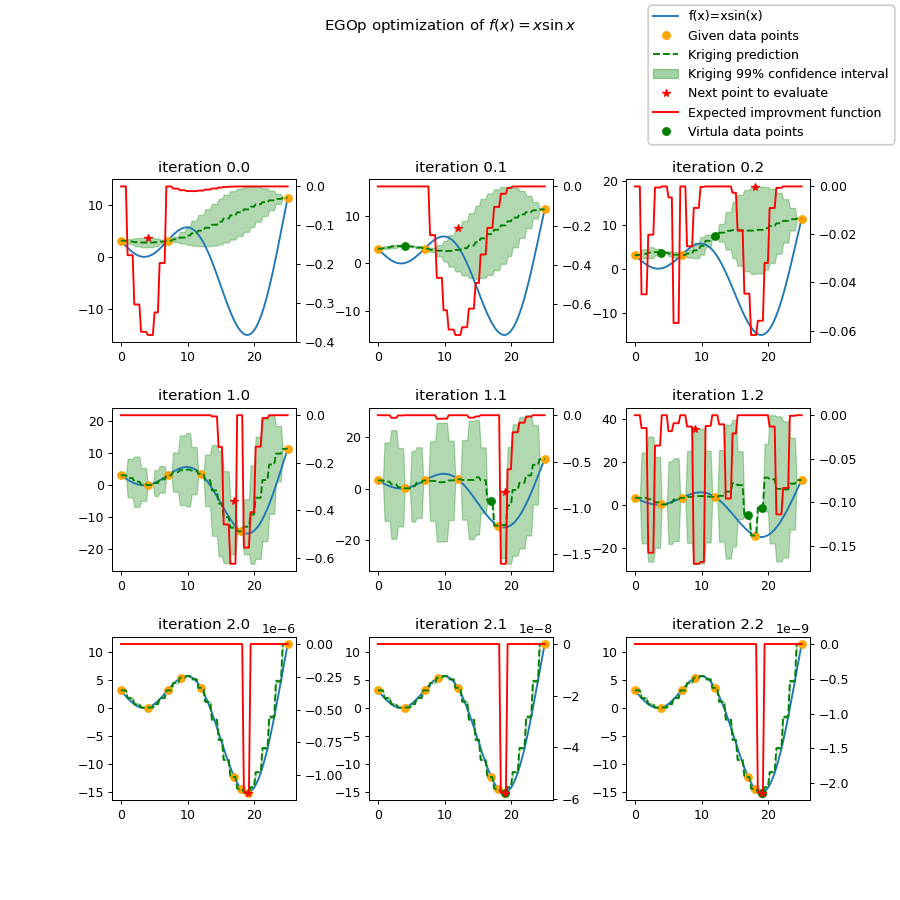

In [34]:
from smt.applications.ego import Evaluator

n_iter = 3
n_parallel = 3
n_start = 50
xlimits = np.array([[0.0, 25.0]])
xdoe = np.atleast_2d([0, 7, 25]).T
n_doe = xdoe.size

class ParallelEvaluator(Evaluator):
    """
    Implement Evaluator interface using multiprocessing ThreadPool object (Python 3 only).
    """

    def run(self, fun, x):
        n_thread = 5
        # Caveat: import are made here due to SMT documentation building process
        import numpy as np
        from sys import version_info
        from multiprocessing.pool import ThreadPool

        if version_info.major == 2:
            return fun(x)
        # Python 3 only
        with ThreadPool(n_thread) as p:
            return np.array(
                [
                    y[0]
                    for y in p.map(
                        fun, [np.atleast_2d(x[i]) for i in range(len(x))]
                    )
                ]
            )

criterion = "EI"  #'EI' or 'SBO' or 'LCB'
qEI = "KBUB"  # "KB", "KBLB", "KBUB", "KBRand"
ego = EGO(
    xdoe=xdoe,
    n_iter=n_iter,
    criterion=criterion,
    surrogate=sm,
    n_parallel=n_parallel,
    qEI=qEI,
    n_start=n_start,
    evaluator=ParallelEvaluator(),
    random_state=42,
)

x_opt, y_opt, _, x_data, y_data = ego.optimize(fun=fun)
print("Minimum in x={:.1f} with f(x)={:.1f}".format(float(x_opt), float(y_opt)))

x_plot = np.atleast_2d(np.linspace(0, 25, 100)).T
y_plot = fun(x_plot)

fig = plt.figure(figsize=[10, 10])
for i in range(n_iter):
    k = n_doe + (i) * (n_parallel)
    x_data_k = x_data[0:k]
    y_data_k = y_data[0:k]
    x_data_sub = x_data_k.copy()
    y_data_sub = y_data_k.copy()
    for p in range(n_parallel):
        ego.gpr.set_training_values(x_data_sub, y_data_sub)
        ego.gpr.train()

        y_ei_plot = -ego.EI(x_plot)
        y_gp_plot = ego.gpr.predict_values(x_plot)
        y_gp_plot_var = ego.gpr.predict_variances(x_plot)

        x_data_sub = np.append(x_data_sub, x_data[k + p])
        y_KB = ego._get_virtual_point(np.atleast_2d(x_data[k + p]), y_data_sub)

        y_data_sub = np.append(y_data_sub, y_KB)

        ax = fig.add_subplot(n_iter, n_parallel, i * (n_parallel) + p + 1)
        ax1 = ax.twinx()
        (ei,) = ax1.plot(x_plot, y_ei_plot, color="red")

        (true_fun,) = ax.plot(x_plot, y_plot)
        (data,) = ax.plot(
            x_data_sub[: -1 - p],
            y_data_sub[: -1 - p],
            linestyle="",
            marker="o",
            color="orange",
        )
        (virt_data,) = ax.plot(
            x_data_sub[-p - 1 : -1],
            y_data_sub[-p - 1 : -1],
            linestyle="",
            marker="o",
            color="g",
        )

        (opt,) = ax.plot(
            x_data_sub[-1], y_data_sub[-1], linestyle="", marker="*", color="r"
        )
        (gp,) = ax.plot(x_plot, y_gp_plot, linestyle="--", color="g")
        sig_plus = y_gp_plot + 3.0 * np.sqrt(y_gp_plot_var)
        sig_moins = y_gp_plot - 3.0 * np.sqrt(y_gp_plot_var)
        un_gp = ax.fill_between(
            x_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
        )
        lines = [true_fun, data, gp, un_gp, opt, ei, virt_data]
        fig.suptitle("EGOp optimization of $f(x) = x \sin{x}$")
        fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
        ax.set_title("iteration {}.{}".format(i, p))
        fig.legend(
            lines,
            [
                "f(x)=xsin(x)",
                "Given data points",
                "Kriging prediction",
                "Kriging 99% confidence interval",
                "Next point to evaluate",
                "Expected improvment function",
                "Virtula data points",
            ],
        )
plt.show()

<div class="alert alert-warning" >
If you use hierarchical variables and the size of your doe greater than 30 points, you may leverage the `numba` JIT compiler to speed up the computation
To do so:
    
 - install numba library
    
     `pip install numba`
    
    
 - and define the environment variable `USE_NUMBA_JIT = 1` (unset or 0 if you do not want to use numba) 
    
     - Linux: export USE_NUMBA_JIT = 1
    
     - Windows: set USE_NUMBA_JIT = 1

</div>